### Load Mujoco Engine

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r, get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'shoulder_link', None, None, None, None, 'upper_arm_link_1', 'upper_arm_link_2', None, None, None, None, 'forearm_link_1', 'forearm_link_2', None, None, None, 'wrist_1_link', None, None, None, 'wrist_2_link_1', 'wrist_2_link_2', None, 'wrist_3_link', 'tcp_link', 'camera_mount', 'camera_mounted_gear', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylinder_07', 'obj_cylinder_08']
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_

In [3]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] not in list1:
        idxs_step.append(list1.index(list2[i]))
        

In [4]:
joint_value = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]
q_init = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]

### Nullspace projected IK with task space target

In [5]:
env.init_viewer(viewer_title='IK using UR5e',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.reset() # reset

# Set the primary and the secondary IK targets
ik_body_name_pri = 'tcp_link'
ik_body_name_sec = 'wrist_3_link'
delta_p =  (env.get_p_body(ik_body_name_pri)-env.get_p_body(ik_body_name_sec))
R_ = env.get_R_body(ik_body_name_sec)
p_offset = R_.T @ delta_p

p_trgt_pri = np.array([0.9, -0.2, 0.9])
p_trgt_sec = p_trgt_pri - p_offset[[1,0,2]]

# Loop
q = env.get_q(joint_idxs=idxs_jacobian)
imgs,img_ticks,max_tick = [],[],200
while (env.tick < max_tick) and env.is_viewer_alive():
    # Get IK ingredients for the primary target
    J_pri,err_pri = env.get_ik_ingredients(
        body_name=ik_body_name_pri,p_trgt=p_trgt_pri,R_trgt=None,IK_P=True,IK_R=False)
    dq_pri = env.damped_ls(J_pri,err_pri,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    # Get IK ingredients for the nullspace
    J_sec,err_sec = env.get_ik_ingredients(
        body_name=ik_body_name_sec,p_trgt=p_trgt_sec,R_trgt=None,IK_P=True,IK_R=False)
    dq_sec = env.damped_ls(J_sec,err_sec,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    # Combine the primary with the secondary with nullspace projection
    dq = dq_pri + (np.eye(env.n_dof,env.n_dof)-np.linalg.pinv(J_pri)@J_pri)@dq_sec;
    # Update q and FK
    q = q + dq[idxs_jacobian]
    env.forward(q=q,joint_idxs=idxs_forward)
    # Render
    env.plot_T(p=env.get_p_body(body_name=ik_body_name_pri),R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[1,0,0,0.9])
    env.plot_T(p=p_trgt_pri,R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[0,0,1,0.9])
    env.plot_T(p=env.get_p_body(body_name=ik_body_name_sec),R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[1,0,0,0.9])
    env.plot_T(p=p_trgt_sec,R=None,
               PLOT_AXIS=False,PLOT_SPHERE=True,sphere_r=0.05,sphere_rgba=[0,0,1,0.9])
    env.plot_T(p=[0,0,0],R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0)
    env.render()
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        print ("[%d/%d] IK error primary:[%.4f] secondary:[%.4f]"%
               (env.tick,max_tick,np.linalg.norm(err_pri),np.linalg.norm(err_sec)))
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)
# Close viewer
env.close_viewer()
print ("Done.")

[1/200] IK error primary:[0.6108] secondary:[0.3846]
[20/200] IK error primary:[0.0005] secondary:[0.1482]
[40/200] IK error primary:[0.0001] secondary:[0.1210]
[60/200] IK error primary:[0.0000] secondary:[0.0843]
[80/200] IK error primary:[0.0000] secondary:[0.0559]
[100/200] IK error primary:[0.0000] secondary:[0.0356]
[120/200] IK error primary:[0.0000] secondary:[0.0216]
[140/200] IK error primary:[0.0000] secondary:[0.0125]
[160/200] IK error primary:[0.0000] secondary:[0.0070]
[180/200] IK error primary:[0.0000] secondary:[0.0038]
[200/200] IK error primary:[0.0000] secondary:[0.0021]
Done.


### Using a function: `solve_nullspace_projected_ik`

In [6]:
env.init_viewer(viewer_title='IK using UR5e',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.reset() # reset

q_null_ik = env.solve_nullspace_projected_ik(ik_body_name_pri = 'tcp_link', ik_body_name_sec='wrist_3_link',
                    p_trgt_pri=np.array([0.7, 0.3, 1.1]), p_trgt_sec=np.array([0.6,0.3,1.4]),
                    R_trgt_pri=rpy2r(np.array([0, 1 * np.pi, -0.5 *np.pi])),
                    R_trgt_sec=rpy2r(np.array([0, 0, 0])),
                    IK_Ps = [True,True], IK_Rs = [False,False],
                    q_init=q_init, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
                    RESET=True,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th_pri=1e-6, err_th_sec=0.3)

# Close viewer
env.close_viewer()
print ("Done.")

Done.


In [7]:
times,q_null_traj = get_interp_const_vel_traj(
    np.vstack((q_init,q_null_ik)),vel=np.radians(20),HZ=env.HZ)
print ("Joint trajectory ready. duration:[%.2f]sec"%(times[-1]))

traj_null_len = q_null_traj.shape[0]

Joint trajectory ready. duration:[5.81]sec


Pressed ESC
Quitting.


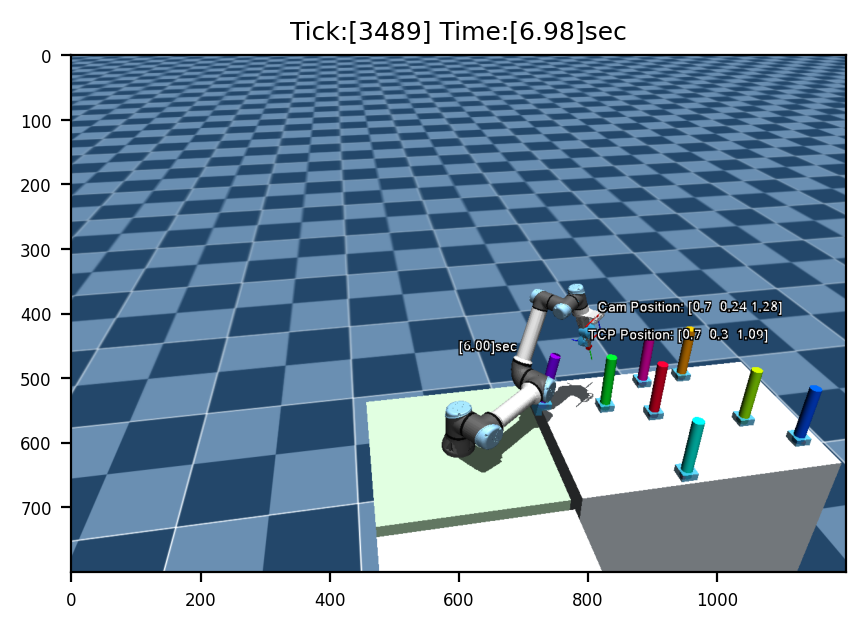

Done.


In [8]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=q_init,joint_idxs=idxs_forward)

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1

    if tick >= traj_null_len-1:
        q = q_null_traj[-1,:]
    else:
        q = q_null_traj[tick,:]
        
    env.step(ctrl=q, ctrl_idxs=idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")